In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import (create_eog_epochs, create_ecg_epochs,
                               compute_proj_ecg, compute_proj_eog)
import scipy.io
import scipy.interpolate
from scipy import signal
from matplotlib import patches
from IPython.display import HTML

from mne.datasets import fetch_fsaverage
import os.path as op

from mne.minimum_norm import apply_inverse, make_inverse_operator

plt.rcParams['figure.figsize'] = [10, 5]

--------------

# USER INPUT: specify start time, end time, animation specific parameters

In [52]:
# ALLOW USER TO SPECIFY DATASET

# Specify electrode layout
electrode_layout = 'standard_1020' # toggle to switch to 'standard_1005' if needed, default to 'standard_1020'.

# Calculate starting/ending frames
start_hour = 0
start_minute = 2
start_second = 34
start_ms = 0

end_hour = 0
end_minute = 2
end_second = 34
end_ms = 200

-------

# Preparing/ Loading/ Creating Neccesary Data

## Data needed for all visualizations

### Load dataset + set EEG reference + set montage (electrode layout)

In [3]:
# Load raw dataset from .set file (also requires .fdt file to be in same locaiton)
raw = mne.io.read_raw_eeglab('../data/1122/fixica.set')

# Set EEG reference
raw = raw.set_eeg_reference(projection=True)

# Read and set the EEG electrode locations
montage = mne.channels.make_standard_montage(electrode_layout)
#raw.set_montage(montage) #PROBLEM, CURRENTLY CAUSES THE 2D TOPOGRAPHIC MAP TO BREAK, Doesn't seem necceasry though

Reading /Users/mpin/Documents/MDS/capstone/simpl_eeg_capstone/data/1122/fixica.fdt


<ipython-input-3-09efae4a35a7>:2: RuntimeWarning: Data file name in EEG.data (1122 fix ica.fdt) is incorrect, the file name must have changed on disk, using the correct file name (fixica.fdt).
  raw = mne.io.read_raw_eeglab('../data/1122/fixica.set')


Adding average EEG reference projection.
1 projection items deactivated


In [59]:
type(raw)

mne.io.eeglab.eeglab.RawEEGLAB

In [4]:
raw.to_data_frame()

,time,Fp1,Fp2,F7,T3,T5,F3,C3,P3,Fz,Cz,Pz,F4,C4,P4,F8,T4,T6,O1,O2
0,0,14.531582,-11.783981,21.614923,16.321362,9.719512,27.709532,20.624149,-12.324463,31.250061,-17.420900,-0.604612,22.614033,13.405896,14.801276,9.054724,31.453531,65.513573,19.535841,66.734680
1,0,14.663340,-11.556257,21.842810,16.447823,9.707135,27.960907,20.854715,-12.314746,31.550734,-17.250202,-0.397661,22.628576,13.758141,14.799129,9.227283,31.685881,65.872292,19.772394,67.123322
2,1,-3.443891,1.930776,-4.740189,0.788001,8.453854,-3.462852,9.965158,12.098608,-8.166456,3.516325,4.724171,-3.717364,-4.112843,1.038013,-2.150941,-6.353374,-14.303813,-7.936352,-11.684968
3,1,-3.307942,2.099311,-4.528029,0.920528,8.478236,-3.215314,10.189683,12.130275,-7.876774,3.677025,4.921148,-3.652322,-3.781625,1.081903,-1.999602,-6.113438,-13.906372,-7.695049,-11.297887
4,2,-20.129866,11.896512,-26.603367,-19.898535,-9.397938,-34.980213,-24.516251,11.010246,-39.996239,10.851233,-3.995591,-30.502254,-22.746386,-23.825443,-12.020208,-40.792339,-84.599731,-29.124195,-71.566116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12026814,5872468,0.431599,-11.203208,-5.401009,-8.842719,-21.067455,-5.125039,-13.202153,-17.706484,-3.385837,-4.494127,-10.534277,10.303233,-0.655697,-3.229792,0.609808,2.967641,4.266589,-12.140933,-21.257788
12026815,5872468,-1.489737,-10.815990,-6.092179,-8.904007,-18.108355,-7.078905,-13.184569,-16.075550,-6.267701,-8.176545,-11.692679,5.932804,-3.483309,-6.786361,-0.193163,1.509319,2.484582,-18.077801,-24.505026
12026816,5872469,-1.968966,-9.105274,-6.192163,-9.354151,-19.288197,-6.856446,-12.696264,-17.376734,-5.699758,-8.334212,-12.509238,4.847283,-4.542382,-8.081605,0.227286,-0.522487,-3.278140,-19.413612,-23.679283
12026817,5872469,-2.041348,-3.647175,-3.493313,-5.040982,-10.048667,-3.964209,-5.937623,-10.364542,-3.652566,-7.439807,-11.316919,0.339351,-3.996915,-8.074924,0.826789,-1.911655,-6.392892,-16.061987,-16.736626


### Calculate frame to start/end animations on

In [5]:
sampling_freq_hz = raw.info.get('sfreq') 

start_frame = round((sampling_freq_hz/1000) * start_ms) \
    + (start_second * sampling_freq_hz) \
    + (start_minute * (sampling_freq_hz * 60)) \
    + (start_hour * (sampling_freq_hz * 3600))

end_frame = round((sampling_freq_hz/1000) * end_ms) \
    + (end_second * sampling_freq_hz) \
    + (end_minute * (sampling_freq_hz * 60)) \
    + (end_hour * (sampling_freq_hz * 3600))

duration = (end_frame - start_frame) / sampling_freq_hz # duration of specified window in seconds

print("start frame is", start_frame, "at", str(start_hour) + ":" + str(start_minute) + ":" + str(start_second) + "." + str(start_ms))
print("end frame is", end_frame, "at", str(end_hour) + ":" + str(end_minute) + ":" + str(end_second) + "." + str(end_ms))
print("duration is", duration, "seconds")

start frame is 315392.0 at 0:2:34.0
end frame is 315802.0 at 0:2:34.200
duration is 0.2001953125 seconds


In [6]:
# Set up events and use it to generate mock epoch and evoked data

user_event_frame = round((start_frame + end_frame)/2) # Pick frame in the middle of the two specified frames to build epoch around
user_event = ([[int(user_event_frame), 0, 1]]) # Format event to make mock epoch
user_event = np.array(user_event)

min_time = 0 - duration/2 # time to start from before epoch, should line up with user specified start time
max_time = 0 + duration/2 # time to stop from after epoch time, should line up with user specified end time

 # Doesn't seem to like this version which starts the epoch at 0 rather than in the middle, might be better if it's possible
# user_event_frame = start_frame 
# user_event = ([[int(user_event_frame), 0, 1]])
# user_event = np.array(user_event)

# min_time = 0
# max_time = duration

-----------

## Data needed for 2D topographic map, 3D brain map

### Create mock epoch and evoked data from timestamp - IS TIMESTAMP SPECIFIC

In [74]:
%%time 
event_dict = {'user_specified_time': 1} # Create single mock event, needed to make epoch 

user_epoch = mne.Epochs(raw,
                        user_event,
                        tmin = min_time,
                        tmax = max_time,
                        event_id = event_dict,
                        preload=True)

user_evoked = user_epoch['user_specified_time'].average()

Not setting metadata
Not setting metadata
1 matching events found
Setting baseline interval to [-0.10009765625, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 1 events and 411 original time points ...
0 bad epochs dropped
CPU times: user 13.6 ms, sys: 5.28 ms, total: 18.9 ms
Wall time: 16.7 ms


In [81]:
user_epoch.get_data()[0]

array([[ 8.56077950e-07,  4.83310035e-08,  2.65115616e-07, ...,
        -3.16580107e-06, -3.44658619e-06, -2.99997257e-06],
       [-5.00157752e-06, -2.85553941e-06, -3.49731565e-06, ...,
        -8.41321575e-07,  1.47570556e-06,  5.76367206e-07],
       [-1.01265381e-06, -5.28633037e-07, -9.39011179e-07, ...,
        -1.34366983e-06, -6.70880808e-07, -8.86494315e-07],
       ...,
       [ 2.33595441e-06,  9.84885978e-07, -7.56008026e-07, ...,
         4.82184317e-06,  4.35377486e-06,  6.47431012e-06],
       [ 2.88745951e-06,  3.48037021e-06,  2.54841269e-06, ...,
         4.58507779e-06,  8.40809591e-06,  6.44390508e-06],
       [ 9.81023550e-07,  1.46568119e-07,  4.17766944e-07, ...,
        -1.18201457e-07,  2.59722019e-07, -8.15043239e-07]])

-------

## Data needed for 3D brain map

### Loading stock MRI data (a brain to map to) - NOT TIMESTAMP SPECIFIC, NOT DATASET SPECIFIC, NEEDED FOR: "Creating forward"

In [8]:
%%time

# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# Used to download/load example MRI brain model
# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

0 files missing from root.txt in /Users/mpin/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage
CPU times: user 4.33 ms, sys: 3.88 ms, total: 8.21 ms
Wall time: 8.44 ms


### Creating forward (3D spatial data of brain + mapping) - NOT TIMESTAMP SPECIFIC, DATASET SPECIFIC

In [9]:
%%time

fwd = mne.make_forward_solution(raw.info,
                                trans=trans,
                                src=src,
                                bem=bem,
                                eeg=True,
                                mindist=5.0,
                                n_jobs=1)
print(fwd)

Source space          : /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /Users/mpin/opt/miniconda3/lib/python3.8/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /Users/mpin/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  19 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BEM model 

### Creating Covariance + Inverse Operator (takes a long time) - NOT TIMESTAMP SPECIFIC, DATASET SPECIFIC¶

In [10]:
%%time

# NOT TIMESTAMP SPECIFIC
noise_cov = mne.compute_raw_covariance(
    raw,
    method=['empirical', 'shrunk'])

Using up to 29362 segments
Computing rank from data with rank=None
    Using tolerance 2.5e-10 (2.2e-16 eps * 19 dim * 6e+04  max singular value)
    Estimated rank (eeg): 18
    EEG: rank 18 computed from 19 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 19 -> 18
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using SHRUNK
Done.
Using cross-validation to select the best estimator.
Number of samples used : 12038420
log-likelihood on unseen data (descending order):
   shrunk: -27.966
   empirical: -164.172
selecting best estimator: shrunk
[done]
CPU times: user 10min 34s, sys: 1min 48s, total: 12min 22s
Wall time: 5min 8s


In [11]:
%%time
# make an MEG inverse operator
info = user_evoked.info
inverse_operator = make_inverse_operator(info,
                                         fwd,
                                         noise_cov,
                                         loose=0.2,
                                         depth=0.8)

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 19 channels.
    19 out of 19 channels remain after picking
Selected 19 channels
Creating the depth weighting matrix...
    19 EEG channels
    limit = 20485/20484 = 9.583809
    scale = 9.50316e+09 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.3e-14 (2.2e-16 eps * 19 dim * 3  max singular value)
    Estimated rank (eeg): 18
    EEG: rank 18 computed from 19 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD 

## Creating inverse solution (STC) - IS TIMESTAMP SPECIFIC

In [12]:
%%time

# Unsure about these values for the time being, currently using defaults from MNE documentation
snr = 3.0
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

# Compute inverse solution
stc = apply_inverse(user_evoked,
                    inverse_operator,
                    lambda2,
                    method,
                    pick_ori='normal')

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 18 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "user_specified_time"...
    Picked 19 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  99.7% variance
    dSPM...
[done]
CPU times: user 1.73 s, sys: 75.8 ms, total: 1.81 s
Wall time: 257 ms


-------

# Visualization Functions

### Raw Voltage Values

Required data objects...
- timestamp data

Currently saves as...


-----

### 2D topographic map

Required data objects...
- raw
- timestamp data
- evoked

Currently saves as...
- HTML animation

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

In [225]:
# Advanced user input options for PLOTTING 2d topomap image
mark = 'channel_name' # "dot" default. Options include "r+", "channel_name", "none"
contours = 6 # Number of lines that divide up sections to be drawn in the topomap
vmin_mu_V_2d = -10 # Minimum topomap value in Microvolts (µV), -10 will be default
vmax_mu_V_2d = 10 # Maximum topomap value in Microvolts (µV), 10 will be default
colormap_2d = 'RdBu_r' # 'RdBu_r' default. Options include 'PuOr', 'PRGn', 'PiYG', 'RdGy', 'RdYlBu' 

# Advanced user input options for ANIMATING 2d topomap
colorbar = True # True by default. Whether to include colorbar or not. 
show_every_nth_frame = 1 # '3' is default, higher numbers used to plot choppier animation for to save speed/memory
frame_rate_2d = 12
# Consider making an auto_calculate option in case a user specifies a really long length
# Consider options for extrapolate
# Consider options for outline

CPU times: user 23.9 s, sys: 983 ms, total: 24.9 s
Wall time: 3.53 s


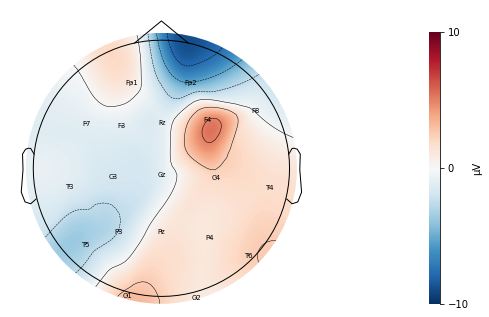

In [226]:
%%time

from IPython.display import HTML
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig, ax = plt.subplots()

sensor_value = False; names_value = False; show_names_value = False;

if mark == 'dot':
    sensor_value = True; names_value = False; show_names_value = False;
if mark == 'r+':
    sensor_value = 'r+'; names_value = False; show_names_value = False;
if mark == 'channel_name':
    sensor_value = True; names_value = raw.ch_names; show_names_value = True;
if mark == 'none':
    sensor_value = False; names_value = False; show_names_value = False;


# if show_every_nth_frame == 1:
#     frames_value = user_epoch.get_data().shape[2]
# else:
#     frames_value = np.arange(0,user_epoch.get_data().shape[2], show_every_nth_frame)
    
frames_value = np.arange(0,user_epoch.get_data().shape[2], show_every_nth_frame)




def animate_2D_topomap(frame_number):
    fig.clear()
    # https://mne.tools/dev/generated/mne.viz.plot_topomap.html
    topomap_2d = mne.viz.plot_topomap(data = user_evoked.data[:, frame_number],
                         pos = raw.info, # Location info for data points
                         show=False,
                         vmin = vmin_mu_V_2d/1e6, # Convert back to volts
                         vmax = vmax_mu_V_2d/1e6,
                         sphere = 100, # Causes head to appear, see documentation, not sure what value should be here so 100 is placeholder
                         outlines = 'head', # 'head' keeps signals within head space, 'skirt' extrapolates beyond PROBS LEAVE ON 'head'
                         extrapolate = "head", # 'local' is off-center. PROBS LEAVE ALWAYS ON 'head'
                         #res = 100, # n x n pixels in the actual waves MAYBE USEFUL
                         cmap = colormap_2d, # RdBu_r seems to be the standard PROBS USEFUL
                         sensors = sensor_value, # True = black dots, "r+" = red + MAYBE USEFUL
                         axes = None, # used if you're plotting multiple images PROBS NOT USEFUL
                         names = names_value, # Feed in channel names MAYBE USEFUL
                         show_names = show_names_value, # Show channel names at each location MAYBE USEFUL
                         mask = None, # Marks siginficant points/times if that's wanted PROBABLY NOT USEFUL
                         mask_params = None, # PROBABLY NOT USEFUL
                         contours = 6, # Number of lines that divide up sections to be drawn MAYBE USEFUL
                         # image_interp = 'nearest', # Can change how heatmap is drawn PROBABLY NOT USEFUL
                         # onselect = 'RectangeSelector', # Supposed to add interactivity PROBABLY NOT USEFUL for animation
                        )[0];
    
    # Consider changing to screenshot of colorbar genearted at the start to increase calculation speed
    if colorbar == True:
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("right", size="2%", pad="0%")
        clim = dict(kind='value', lims=[vmin_mu_V_2d , 0, vmax_mu_V_2d])
        # https://mne.tools/stable/generated/mne.viz.plot_brain_colorbar.html
        mne.viz.plot_brain_colorbar(cax,
                                    clim,
                                    colormap= topomap_2d.get_cmap().name, # get same cmap that's in the 2D topomap
                                    transparent=False,
                                    orientation='vertical',
                                    label='µV',
                                    bgcolor='0')

    
ms_between_frames = 1000/frame_rate_2d  
ani = animation.FuncAnimation(fig,
                              animate_2D_topomap,
                              frames = frames_value, #user_epoch.get_data().shape[2] for full animation
                              interval = ms_between_frames, # Time between frames in ms
                              blit=False)

HTML(ani.to_jshtml())

-----

### 3D Topographic Skull Map

Required data objects...
- timestamp data

Currently saves as...



--------

### 3D Topographic Brain Map

Required data objects...
- Inverse operator (stc)

Currently saves as...
- Gif

In [49]:
# 3D brain map advanced options

brain_3d_hemi = 'both' # 'both' is default. 'split', 'lh', 'rh' are other options
brain_3d_views = ['lateral', 'dorsal','coronal', 'frontal'] # Reccomended default
    # options are 'lateral', 'medial', 'rostral', 'caudal', 'dorsal',
    # 'ventral','frontal', 'parietal', 'axial', 'sagittal', 'coronal'

brain_3d_colormap = 'mne' # Default should be 'mne' (shows brain texture)


brain_3d_color_type = 'auto' # Defaults to 'auto' but can also pick 'pos_lims_value', 'lims_value', 'lims_percent', 'pos_lims_percent'

# Manual entry values if 'brain_3d_color_type' is not set to auto
brain_3d_vmin_mu_V = 0
brain_3d_vmid_mu_V = 8
brain_3d_vmax_mu_V = 10



brain_3d_plot_size = (800, 1000)

In [50]:
# https://mne.tools/stable/generated/mne.SourceEstimate.html#mne.SourceEstimate.plot

if brain_3d_color_type == 'auto':
    brain_3d_clim_values = 'auto'
else:
    if brain_3d_color_type == 'lims_value':
        brain_3d_clim_type = 'value'; brain_3d_lims = 'lims'
    elif brain_3d_color_type == 'pos_lims_value':
        brain_3d_clim_type = 'value'; brain_3d_lims = 'pos_lims'
    elif brain_3d_color_type == 'lims_percent':
        brain_3d_clim_type = 'percent'; brain_3d_lims = 'lims'
    elif brain_3d_color_type == 'pos_lims_percent':
        brain_3d_clim_type = 'percent'; brain_3d_lims = 'pos_lims'
    if brain_3d_lims == 'pos_lims':
        brain_3d_clim_values = dict(kind=brain_3d_clim_type,
                                    pos_lims=[brain_3d_vmin_mu_V,
                                              brain_3d_vmid_mu_V,
                                              brain_3d_vmax_mu_V]
                                   )
    elif brain_3d_lims == 'lims':
        brain_3d_clim_values = dict(kind=brain_3d_clim_type,
                                    lims=[brain_3d_vmin_mu_V,
                                          brain_3d_vmid_mu_V,
                                          brain_3d_vmax_mu_V]
                                   )


brain = stc.plot(views= brain_3d_views,
                 surface = 'inflated', # white is the other option (but I hate it)
                 hemi= brain_3d_hemi,
                 colormap = brain_3d_colormap,
                 size = brain_3d_plot_size,
                 subject= None,
                 initial_time=0, # For selecting image of individual frame.
                 clim = brain_3d_clim_values,
                 #time_viewer=True, # Use to open up interactive version
                 colorbar = True, 
                 show_traces=False,
                 transparent = False, # Makes values below min fully transparent
                 #alpha = 1.0, # used to make brain transparent
                 #figure = None, # used to attach to other figures
                 #cortex = 'classic', # changes binarized curvature values
                 background = 'black', # changes background color
                 #foreground = "white", # changes color of display text
                 spacing = 'oct6', #changes spacing for souce space. oct6 is default but can use lower number for speed
                 title = '3'
                )

Using control points [15.69868862 18.0315272  33.12694528]


In [51]:
brain.save_movie('test_brain.gif',
                 time_dilation=20,
                 tmin= min_time,
                 tmax= max_time,
                 framerate=10,
                 interpolation='linear',
                 time_viewer=True)

------

### Connectivity visualization

Required data objects...
- timestamp data

Currently saves as...